## This notebook uses pickle file which is generated as part of the modelling step. This branch has corresponding call to create pickle file. Please run the modeling step of pipeline before running the analysis below.

# Importing required packages 

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
from IPython.display import Markdown as md

import sys
sys.path.append("../src/")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


%matplotlib inline

# Loading dataframe used in modeling 

In [2]:
df = pickle.load(open( "../src/model_df.pkl", "rb"))

In [3]:
df.head()

,segment_id,target,pre_week,pre_month,pre_quarter,avg_week,AADT,SPEEDLIMIT,Struct_Cnd,Surface_Tp,...,Surface_Tp8,F_F_Class0,F_F_Class1,F_F_Class2,F_F_Class3,F_F_Class4,F_F_Class5,F_F_Class7,log_AADT,intersection
0,001,0,0,0,0,0.006536,22222,20,2,6,...,0,0,0,0,1,0,0,0,10.008883,0
1,0010017,0,0,0,0,0.006536,0,25,1,6,...,0,0,0,0,0,0,0,1,0.000000,0
2,0010026,0,0,0,0,0.006536,0,20,2,5,...,0,0,0,0,0,0,0,1,0.000000,0
3,0010030,0,0,0,1,0.013072,0,20,1,6,...,0,0,0,0,0,0,0,1,0.000000,0
4,0010041,0,0,0,0,0.006536,0,25,2,6,...,0,0,0,0,0,0,0,1,0.000000,0


# Correlation matrix

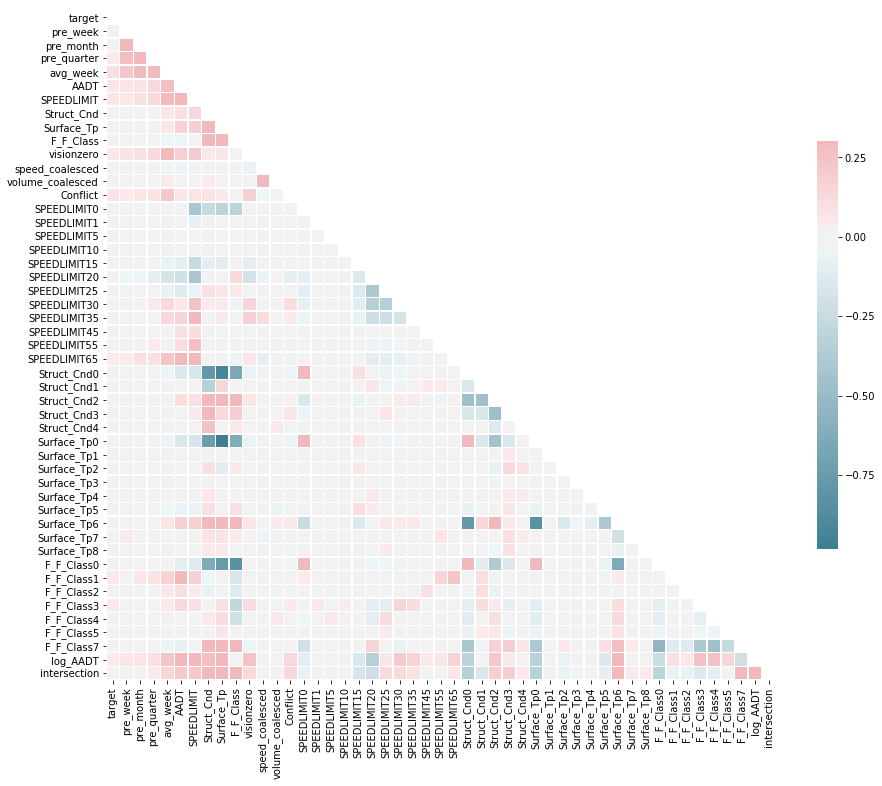

In [4]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation between average weekly crash in a segment with other variables (sorted in desc order)

In [5]:
print(pd.Series(corr["avg_week"]).sort_values())

SPEEDLIMIT20       -0.181346
SPEEDLIMIT25       -0.071514
SPEEDLIMIT15       -0.061495
Surface_Tp0        -0.050694
Struct_Cnd0        -0.049598
F_F_Class7         -0.046966
Surface_Tp5        -0.044542
F_F_Class          -0.044194
speed_coalesced    -0.040782
Surface_Tp2        -0.017831
Surface_Tp4        -0.016765
F_F_Class0         -0.016436
Struct_Cnd1        -0.015650
Surface_Tp8        -0.015067
F_F_Class5         -0.008782
Surface_Tp3        -0.008695
F_F_Class4         -0.007278
Surface_Tp1        -0.006148
SPEEDLIMIT1        -0.004244
SPEEDLIMIT10       -0.003000
SPEEDLIMIT5        -0.002121
Struct_Cnd4        -0.001335
SPEEDLIMIT0        -0.000237
Surface_Tp7         0.007409
SPEEDLIMIT55        0.017311
SPEEDLIMIT45        0.019179
Struct_Cnd2         0.025184
Struct_Cnd3         0.028813
volume_coalesced    0.034539
F_F_Class3          0.050944
Struct_Cnd          0.054975
F_F_Class2          0.055991
Surface_Tp          0.057815
Surface_Tp6         0.070663
target        

## Lower speed limits are ***negatively*** correlated with average crashes in segment

## Visionzero reports, AADT, and high speed limits are ***positively*** correlated with  average crashes in segment

# Descriptive Statistics for average crashes across segments

In [6]:
df.avg_week.describe()

count    4890.000000
mean        0.016515
std         0.023216
min         0.000000
25%         0.006536
50%         0.006536
75%         0.019608
max         0.352941
Name: avg_week, dtype: float64

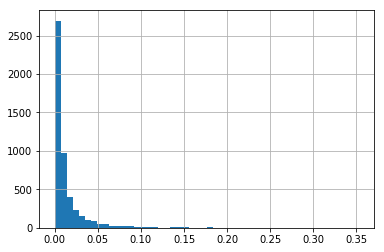

In [7]:
df.avg_week.hist(bins=50)

In [8]:
md("""### Median of average crash per segment is %1.4f , while the average = %1.4f . 
### There are few outliers with high average crashes (4th quantile = %1.4f). The segment %s has the highest average crashes with average per week crash = %1.4f
"""% ( 
    df.avg_week.median() , df.avg_week.mean() , df.avg_week.quantile(0.75),
    df[df.avg_week==df.avg_week.max()].segment_id.values[0] , df.avg_week.max()
    )
  )

### Median of average crash per segment is 0.0065 , while the average = 0.0165 . 
### There are few outliers with high average crashes (4th quantile = 0.0196). The segment 0010989 has the highest average crashes with average per week crash = 0.3529


# In this analysis, we consider segments with top quantile as "High risk" segment

In [9]:
high_risk = pd.Series((df.avg_week > df.avg_week.quantile(0.75)))
high_risk.value_counts()

False    4063
True      827
Name: avg_week, dtype: int64

In [10]:
df_with_crash = df[high_risk]
df_without_crash = df[~high_risk]

In [11]:
df_with_crash.shape , df_without_crash.shape

((827, 52), (4063, 52))

## We are selecting a subset of columns which we will use in further analysis
## Dropping variables like segement_id, target, pre_week,etc  

In [12]:
df_minimal_columns = df[
                        df_with_crash.columns[
                            ~df_with_crash.columns.isin(['segment_id','target','log_AADT','pre_week', 'pre_month', 'pre_quarter','avg_week'])
                        ]
                    ].fillna(0)

In [13]:
df_minimal_columns.columns

Index(['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class',
       'visionzero', 'id', 'speed_coalesced', 'volume_coalesced', 'near_id',
       'Conflict', 'SPEEDLIMIT0', 'SPEEDLIMIT1', 'SPEEDLIMIT5', 'SPEEDLIMIT10',
       'SPEEDLIMIT15', 'SPEEDLIMIT20', 'SPEEDLIMIT25', 'SPEEDLIMIT30',
       'SPEEDLIMIT35', 'SPEEDLIMIT45', 'SPEEDLIMIT55', 'SPEEDLIMIT65',
       'Struct_Cnd0', 'Struct_Cnd1', 'Struct_Cnd2', 'Struct_Cnd3',
       'Struct_Cnd4', 'Surface_Tp0', 'Surface_Tp1', 'Surface_Tp2',
       'Surface_Tp3', 'Surface_Tp4', 'Surface_Tp5', 'Surface_Tp6',
       'Surface_Tp7', 'Surface_Tp8', 'F_F_Class0', 'F_F_Class1', 'F_F_Class2',
       'F_F_Class3', 'F_F_Class4', 'F_F_Class5', 'F_F_Class7', 'intersection'],
      dtype='object')

## To find the variables which make a contribution to a segment being a high risk or not, we use the following approach
## We apply t-test on the continous variables to find if mean of those variables are different in high risk and not high risk segments. We further use p-value to test statistical significance.
## For the boolean variables, we use proportion difference between average crash of high risk and non high-risk segments.


In [14]:
col_with_significance = []
col_with_no_significance = []

for col in df_minimal_columns.columns:
    if (str(df[col].dtype) in ['int64','float64'] and str(col) not in ['SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp','F_F_Class']) :
        val = stats.ttest_ind(df_with_crash[col],df_without_crash[col],equal_var=False)
        col_with_significance.append({ 'pvalue': val.pvalue, 'col': col }) if val.pvalue < 0.05 else   col_with_no_significance.append({ 'pvalue': val.pvalue, 'col': col })
    elif str(df[col].dtype) in ['uint8']:
        val = df_with_crash[col].mean() - df_without_crash[col].mean()
        col_with_significance.append({ 'proportion_difference': val, 'col': col }) if np.abs(val) > 0.05 else   col_with_no_significance.append({ 'proportion_difference': val, 'col': col })


# Features of segment with different distribution in high risk and non high risk segments

In [15]:
pd.DataFrame(col_with_significance)

,col,proportion_difference,pvalue
0,AADT,NaN,2.111291e-31
1,visionzero,NaN,2.069495e-35
2,speed_coalesced,NaN,1.126006e-02
3,volume_coalesced,NaN,4.483281e-03
4,Conflict,NaN,3.378008e-13
5,SPEEDLIMIT20,-0.256045,NaN
6,SPEEDLIMIT25,-0.052504,NaN
7,SPEEDLIMIT30,0.185430,NaN
8,SPEEDLIMIT35,0.100500,NaN
9,SPEEDLIMIT65,0.054938,NaN


# Features of segment with ***similar***  distribution in high risk and non high risk segments ( We will not use these features in further analysis)

In [16]:
pd.DataFrame(col_with_no_significance)

,col,proportion_difference
0,SPEEDLIMIT0,-0.001798
1,SPEEDLIMIT1,-0.000984
2,SPEEDLIMIT5,-0.000246
3,SPEEDLIMIT10,-0.000492
4,SPEEDLIMIT15,-0.037850
5,SPEEDLIMIT45,0.002622
6,SPEEDLIMIT55,0.006431
7,Struct_Cnd1,-0.027076
8,Struct_Cnd3,0.028857
9,Struct_Cnd4,0.002739


# Apply TSNE on the data to visualize how data is distributed

In [17]:
df_input = df_minimal_columns.fillna(0)
X_tsne = TSNE(n_components=2,random_state=12345).fit_transform(df_input)
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]

# We are plotting three TSNE graphs
## with high risk segments only
## with not high risk segments only
## high risk and not high risk segments together (red color for high risk)

## The reason of having three separate graphs is because sometimes points of different overlap each other. So, to avoid such visualization issue, we plot three different plots as mentioned above

## TSNE tries its best to transform how data points are distributed in an N-dimensional space into 2D while preserving the distances between each pair of vector (data point, here segments)

# High Risk Segments are well distributed with some visible clusters

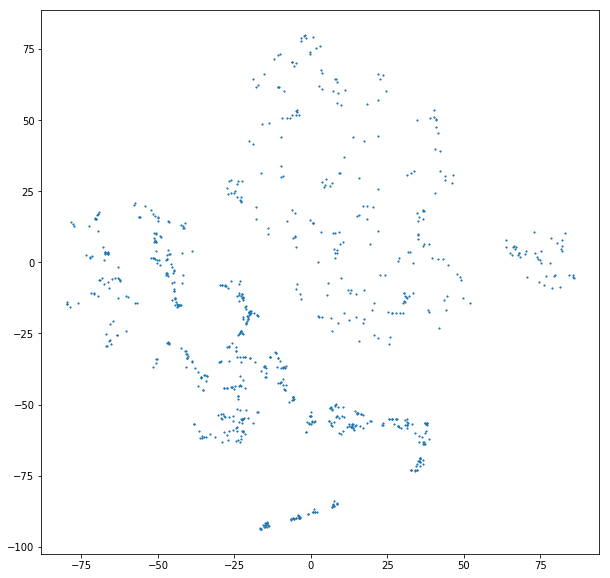

In [18]:
plt.figure(figsize=[10,10])
plt.scatter(
        vis_x[high_risk] ,
        vis_y[high_risk],
        s=1,
        marker="X",
        )

# Non High Risk Segments have similar patterns as high risk segments, though density of non high risk segment is more uniform than high risk segments

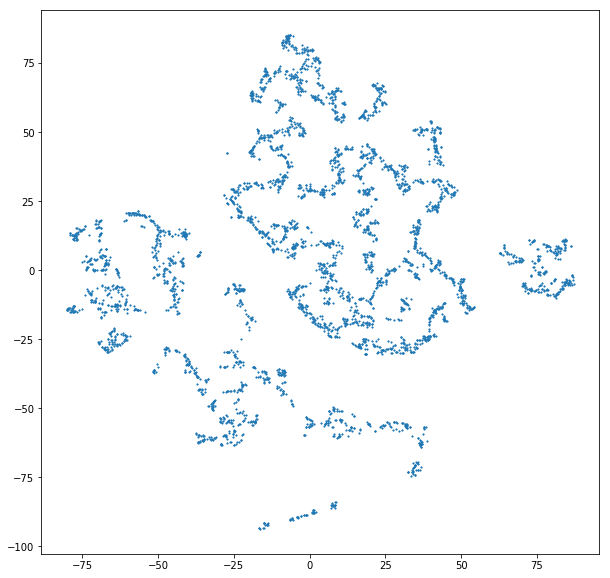

In [19]:
plt.figure(figsize=[10,10])
plt.scatter(
        vis_x[~high_risk] ,
        vis_y[~high_risk],
        s=1,
        marker="X",
        )

# High risk (red) and Non high risk segments are plotted together

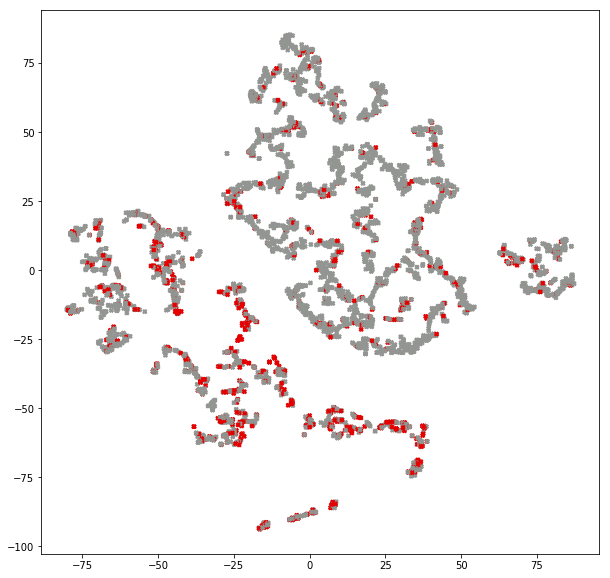

In [20]:
plt.figure(figsize=[10,10])
color_mapping = {0: sns.xkcd_rgb['grey'], 1: sns.xkcd_rgb['red']}
colors = list(map(lambda x: color_mapping[x], high_risk))
plt.scatter(
        vis_x ,
        vis_y,
        s=16,
        marker="X",
        c = colors
        )

# Applying KMeans Clustering and trying to list out characteristics of each cluster

In [21]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

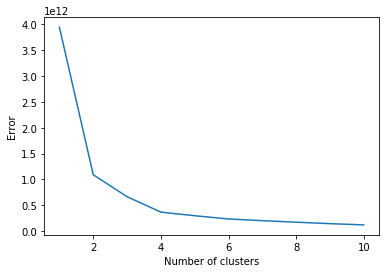

In [22]:
# X_scale = preprocessing.normalize(df_minimal_columns, norm='l2')
evaluate_clusters(df_minimal_columns.fillna(0),10)
plt.show()

In [23]:
from sklearn.cluster import KMeans

#INTEGER FOR RANDOM SEEDING 
random_state = 170

n_clusters = 3

y_pred = KMeans(n_clusters=n_clusters, init='k-means++',random_state=random_state).fit_predict(df_minimal_columns)
cluster_labels = y_pred



In [24]:
cluster_labels

array([0, 2, 2, ..., 2, 2, 0], dtype=int32)

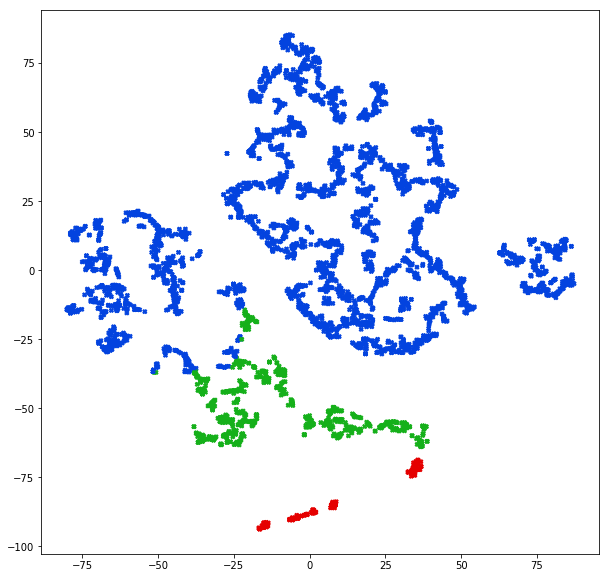

In [25]:
plt.figure(figsize=[10,10])
#vis_x_filtered = vis_x[]
color_mapping = {0: sns.xkcd_rgb['green'], 1: sns.xkcd_rgb['red'], 2: sns.xkcd_rgb['blue'], 3: sns.xkcd_rgb['yellow'], 4: sns.xkcd_rgb['grey']}
colors = list(map(lambda x: color_mapping[x], cluster_labels))
plt.scatter(
        vis_x ,
        vis_y,
        s=16,
        marker="X",
        c = colors
        )

In [26]:
df['cluster_label'] =  cluster_labels
df.head()

,segment_id,target,pre_week,pre_month,pre_quarter,avg_week,AADT,SPEEDLIMIT,Struct_Cnd,Surface_Tp,...,F_F_Class0,F_F_Class1,F_F_Class2,F_F_Class3,F_F_Class4,F_F_Class5,F_F_Class7,log_AADT,intersection,cluster_label
0,001,0,0,0,0,0.006536,22222,20,2,6,...,0,0,0,1,0,0,0,10.008883,0,0
1,0010017,0,0,0,0,0.006536,0,25,1,6,...,0,0,0,0,0,0,1,0.000000,0,2
2,0010026,0,0,0,0,0.006536,0,20,2,5,...,0,0,0,0,0,0,1,0.000000,0,2
3,0010030,0,0,0,1,0.013072,0,20,1,6,...,0,0,0,0,0,0,1,0.000000,0,2
4,0010041,0,0,0,0,0.006536,0,25,2,6,...,0,0,0,0,0,0,1,0.000000,0,2


In [27]:
#checking incidents for each cluster
print("Average Weekly Crash in")

for cluster in set(cluster_labels):
    print("cluster %s : %1.4f"%(str(cluster), df[df['cluster_label'] ==cluster]['avg_week'].mean()))

print("\nMean and median crashes: %1.4f , %1.4f"% (df['avg_week'].mean()  ,df['avg_week'].median() ))

Average Weekly Crash in
cluster 0 : 0.0271
cluster 1 : 0.0378
cluster 2 : 0.0135

Mean and median crashes: 0.0165 , 0.0065


# Next step is to find key characteristics of these clusters
## For that we choose top features which are different in the given cluster when compared with the rest of the clusters
## We select those specific features to explain the characteristics of the clusters
## We could have selected same set of features to explain each cluster but we used this method to focus on the key characteritics of the cluster

### In the given method, we compare each cluster with all points not in the given cluster
### We select the features with lowest p value and print the characteristics of the given cluster

In [28]:
from sklearn.feature_selection import SelectPercentile,f_classif
from sklearn.model_selection import train_test_split


def get_top_features_from_dataset(data, cluster_labels,n_clusters=3):

    temp_labels = []
    dataset = data.as_matrix()
    labels = set(cluster_labels)
    for label in labels:
        revised_labels = pd.Series(cluster_labels)        
        revised_labels = revised_labels.apply(lambda x: 1 if x == label else 0)
        
        X_train, X_test, y_train, y_test = train_test_split(dataset, revised_labels.as_matrix(),random_state=0,test_size=1)
        fscore = f_classif(X_train,y_train)

        top_feature_set = {
            "cluster_label": str(label),
            "names" : list(data.columns.values),
            "scores" : fscore[0].tolist(),
            "pvalues" : fscore[1].tolist()               
        }    
    
        temp_labels.append(top_feature_set)

    return temp_labels

In [29]:
for result in get_top_features_from_dataset(df_minimal_columns, cluster_labels,n_clusters):
    #Get top 5 value of pvalues
    top_5_p_values_indeces = np.argsort(result['pvalues'])[0:8]
    
    print("\n\nCluster : %s"%str(result['cluster_label']))
    print("-------")
    print("Mean crashes: %1.5f"%df[df['cluster_label'] == int(result['cluster_label']) ]['avg_week'].mean())
    print("Characteristics of cluster %s"%str(result['cluster_label']))
    
    tmp_df = pd.DataFrame(columns=['feature_name','mean in cluster','mean (overall)','proportion ratio'])
    
    for index in top_5_p_values_indeces:
        name = result['names'][index]
        tmp_df= tmp_df.append({
            'feature_name': name  ,
            'mean in cluster': df[df['cluster_label'] == int(result['cluster_label']) ][name].mean() ,
            'mean (overall)': df[name].mean(),
            'proportion ratio': df[df['cluster_label'] == int(result['cluster_label']) ][name].mean() / df[name].mean()
        },ignore_index=True)

        
    print(tmp_df.to_string(index=False))
    



Cluster : 0
-------
Mean crashes: 0.02709
Characteristics of cluster 0
feature_name  mean in cluster  mean (overall)  proportion ratio
  F_F_Class3         0.251928        0.064622          3.898506
        AADT     31808.794344    12187.662781          2.609917
SPEEDLIMIT30         0.484576        0.229243          2.113805
SPEEDLIMIT35         0.271208        0.106339          2.550400
  SPEEDLIMIT        30.539846       25.923108          1.178094
SPEEDLIMIT20         0.064267        0.286503          0.224316
  visionzero         2.154242        1.046012          2.059480
intersection         0.723650        0.491820          1.471372


Cluster : 1
-------
Mean crashes: 0.03778
Characteristics of cluster 1
feature_name  mean in cluster  mean (overall)  proportion ratio
        AADT    137177.644970    12187.662781         11.255451
SPEEDLIMIT65         0.479290        0.020859         22.977724
  SPEEDLIMIT        47.248521       25.923108          1.822641
  F_F_Class1         0